# Frequentism vs Bayesianism:  Bayesian Billiard Game

Alice and Bob enter a room. Behind a curtain there is a billiard table, which they cannot see, but their friend Carol can. Carol rolls a ball down the table, and marks where it lands. Once this mark is in place, Carol begins rolling new balls down the table. If the ball lands to the left of the mark, Alice gets a point; if it lands to the right of the mark, Bob gets a point. We can assume for the sake of example that Carol's rolls are unbiased: that is, the balls have an equal chance of ending up anywhere on the table. The first person to reach <b>six points</b> wins the game.

Here the location of the mark (determined by the first roll) can be considered a nuisance parameter: it is unknown, and not of immediate interest, but it clearly must be accounted for when predicting the outcome of subsequent rolls. If the first roll settles far to the right, then subsequent rolls will favor Alice. If it settles far to the left, Bob will be favored instead.

Given this setup, here is the question we ask of ourselves:
>In a particular game, after eight rolls, Alice has five points and Bob has three points. What is the probability that Bob will go on to win the game?


### A Naïve Frequentist Approach

To determine the result, we need an intermediate estimate of where the marker sits

$\hat{p} = 5/8$

$P(B) = (1 - \hat{p})^3$

In [1]:
p_hat = 5/8.
freq_prob_B = (1 - p_hat)**3
print("Naive frequentist, Prob of B winning: {0:.04f}".format(freq_prob_B))
print("Odds against Bob winning: {0:.0f} to 1".format((1. - freq_prob_B) / freq_prob_B))

Naive frequentist, Prob of B winning: 0.0527
Odds against Bob winning: 18 to 1


### Bayesian approach

$B$ = Bob wins

$D$ = Data i.e. (5, 3)

$p$ = unknown probability that a ball lands on Alice's side during the current game

We want to compute P(B|D)

The general Bayesian method of treating nuisance parameters is <b>marginalization</b>, or integrating the joint probability over the entire range of the nuisance parameter. In this case, that means that we will first calculate the joint distribution 

$P(B, p | D)$

and then *marginalize* over $p$ using the following identity: 

$P(B | D) = \int_{-\infty}^{+\infty} P(B, p | D)dp$

This identity follows from the definition of conditional probability, and the law of total probability: that is, it is a fundamental consequence of probability axioms and will always be true. Even a frequentist would recognize this; they would simply disagree with our interpretation of $P(p)$ as being a measure of uncertainty of our own knowledge.

$P(B | D) = \int P(B, p| D) P(p|D) dp$

Bayes rule,

$P(B | D) = \int P(B, p| D) \frac{P(D|p)P(p)}{P(D)} dp $

$P(D)$ = constant, normalization factor$

$P(B | D) = \frac{\int P(B, p| D) P(D|p)P(p) dp}{\int P(D|p)P(p) dp} $

Likelihood Bob wins: $P(B, p| D) = (1 - p)^3$

From Binomial distribution: $P(D|p) \propto p^5(1-p)^3$

$P(p)$: this is our prior on the probability $p$. By the problem definition, we can assume that $p$ is evenly drawn between 0 and 1. That is, $P(p) \propto 1$, and the integrals range from 0 to 1.

$P(B|D) = \frac{\int_0^1 (1-p)^6 p^5 dp}{\int_0^1 (1-p)^3 p^5 dp}$

Beta function: 

$\beta(n,m) = \int_0^1 (1-p)^{n-1} p^{m-1} dp $

In [2]:
from scipy.special import beta
bayes_prob_B = beta(7, 6) / beta(4, 6)

print("P(B|D) = {0:.4f}".format(bayes_prob_B))

P(B|D) = 0.0909


### A Brute Force/Monte Carlo Approach

In [3]:
import numpy as np
np.random.seed(88)

# play 100000 games with randomly-drawn p, between 0 and 1
N = 100000
p = np.random.random(N)

# each game needs at most 11 rolls for one player to reach 6 wins
rolls = np.random.random((11, N))

# count the cumulative wins for Alice and Bob at each roll
Alice_count = np.cumsum(rolls < p, 0)
Bob_count = np.cumsum(rolls >= p, 0)

# sanity check: total number of wins should equal number of rolls
total_wins = Alice_count + Bob_count
assert np.all(total_wins.T == np.arange(1, 12))
print("(Sanity check passed)")

selected_games = Bob_count[7] == 3 # or Alice_count[7] == 5
print("Number of selected games: {0}".format(selected_games.sum()))

# truncate our results to consider only these games
Alice_count = Alice_count[:, selected_games]
Bob_count = Bob_count[:, selected_games]

# determine which of these games Bob won.
# to win, he must reach six wins after 11 rolls.
bob_won = np.sum(Bob_count[10] == 6)
print("Number of these games Bob won: {0}".format(bob_won.sum()))

# compute the probability
mc_prob = bob_won.sum() * 1. / selected_games.sum()
print("Monte Carlo Probability of Bob winning: {0:.4f}".format(mc_prob))
print("MC Odds against Bob winning: {0:.0f} to 1".format((1. - mc_prob) / mc_prob))

(Sanity check passed)
Number of selected games: 11145
Number of these games Bob won: 1015
Monte Carlo Probability of Bob winning: 0.0911
MC Odds against Bob winning: 10 to 1


In [4]:
# generate games
N = 100000
p = np.random.random(N)
rolls = np.zeros((N, 11))
Alice_count = np.zeros((N, 11))
Bob_count = np.zeros((N, 11))

for play in range(N):
    rolls[play, :] = np.random.random(11)
    Alice_count[play, :] = np.cumsum(rolls[play, :] < p[play])
    Bob_count[play, :] = np.cumsum(rolls[play, :] >= p[play])

In [5]:
# select game, at eight game -> A:B = 5:3
selected_games = []
for play in range(N):
    if Bob_count[play, 7] == 3:
        selected_games.append([p[play], Bob_count[play]])

n_select = len(selected_games)
print "Selected games: ", n_select

Selected games:  11022


In [6]:
Bob_win = []
for i, game in enumerate(selected_games):
    if game[1][10] == 6:
        Bob_win.append(game)

In [7]:
print "Monte Carlo Probability of Bob winning:", float(len(Bob_win))/n_select

Monte Carlo Probability of Bob winning: 0.0915441843586


In [8]:
p_select  = []
for game in selected_games:
    p_select.append(game[0])

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

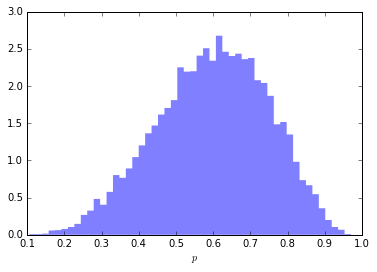

In [10]:
plt.hist(p_select, normed=1, bins=50, histtype="stepfilled", alpha=0.5, lw=0)
plt.xlabel(r"$p$")
plt.show()